In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '../content/drive/MyDrive/Garbage classification'

In [ ]:
total_dir = len(os.listdir(data_dir))
total_files = 0

for dirname, _, filenames in os.walk(data_dir):
    print('counting:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('total files in dir:', files_counter)

print('--------')
print('total number of files',total_files)
print('total number of directories',total_dir)


counting: ../content/drive/MyDrive/Garbage classification
total files in dir: 0
counting: ../content/drive/MyDrive/Garbage classification/plastic
total files in dir: 482
counting: ../content/drive/MyDrive/Garbage classification/trash
total files in dir: 137
counting: ../content/drive/MyDrive/Garbage classification/metal
total files in dir: 410
counting: ../content/drive/MyDrive/Garbage classification/cardboard
total files in dir: 403
counting: ../content/drive/MyDrive/Garbage classification/glass
total files in dir: 501
counting: ../content/drive/MyDrive/Garbage classification/paper
total files in dir: 594
--------
total number of files 2527
total number of directories 6


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


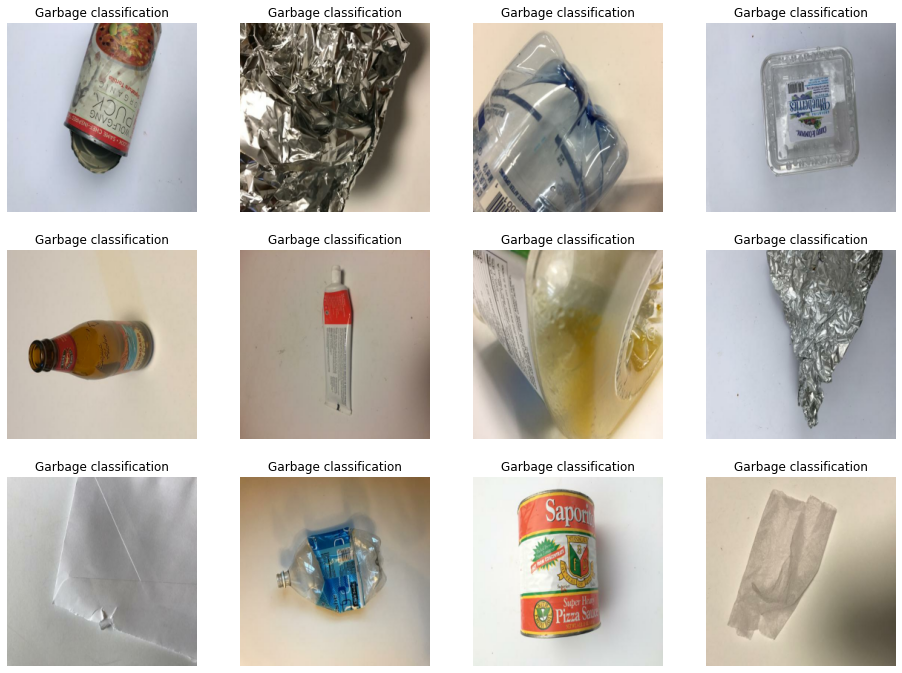

In [ ]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

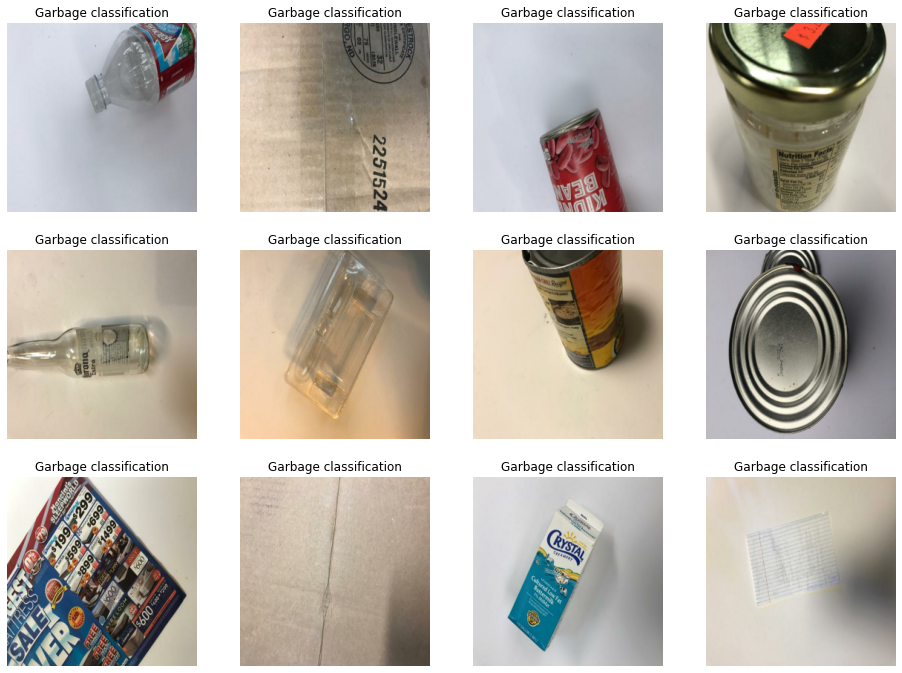

In [ ]:
plt.figure(figsize=(16, 16))
for images, labels in validation_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
train_batch = train_ds.as_numpy_iterator().next()

print('total of batches:',len(train_ds))
print('images batch shape:',train_batch[0].shape)
print('labels batch shape:',train_batch[1].shape)

total of batches: 64
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [ ]:
validation_batch = validation_ds.as_numpy_iterator().next()

print('total of batches:',len(validation_ds))
print('images batch shape:',validation_batch[0].shape)
print('labels batch shape:',validation_batch[1].shape)

total of batches: 16
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [ ]:
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)
base_model.trainable = True

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
# review the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

learning_rate = 0.00001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
64/64 [==============================] - 341s 5s/step - loss: 1.5187 - accuracy: 0.4105 - val_loss: 1.1384 - val_accuracy: 0.5960
Epoch 2/10
64/64 [==============================] - 18s 279ms/step - loss: 1.0803 - accuracy: 0.6459 - val_loss: 0.8263 - val_accuracy: 0.7228
Epoch 3/10
64/64 [==============================] - 18s 276ms/step - loss: 0.8601 - accuracy: 0.7196 - val_loss: 0.6811 - val_accuracy: 0.7881
Epoch 4/10
64/64 [==============================] - 18s 269ms/step - loss: 0.7296 - accuracy: 0.7591 - val_loss: 0.5937 - val_accuracy: 0.8218
Epoch 5/10
64/64 [==============================] - 17s 265ms/step - loss: 0.6225 - accuracy: 0.8051 - val_loss: 0.5325 - val_accuracy: 0.8495
Epoch 6/10
64/64 [==============================] - 18s 271ms/step - loss: 0.5499 - accuracy: 0.8299 - val_loss: 0.4864 - val_accuracy: 0.8594
Epoch 7/10
64/64 [==============================] - 18s 272ms/step - loss: 0.5128 - accuracy: 0.8348 - val_loss: 0.4525 - val_accuracy: 0.8653
E

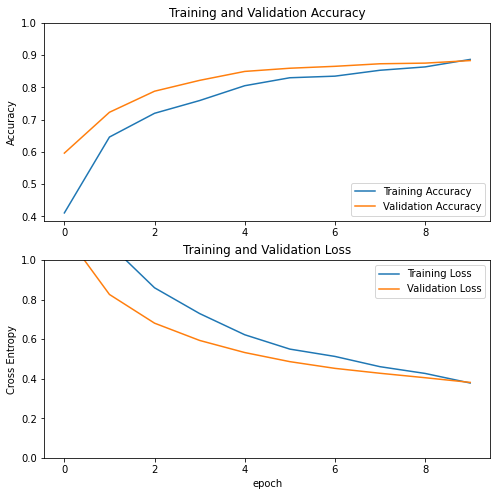

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

16/16 [==============================] - 3s 146ms/step - loss: 0.0029 - accuracy: 1.0000
Test accuracy : 1.0
Test loss: 0.002896706573665142


'metal'

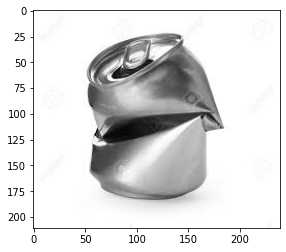

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
path = "/content/drive/MyDrive/metal.jpg"
test_image = image.load_img(path)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.imshow(test_image)
test_img = image.load_img(path, target_size=(256,256))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img,axis=0)
result = model.predict(test_img)
a = result.argmax()
s = train_ds.class_names
name = [ ]
for i in s:
     name.append(i)
for i in range(len(s)):
     if (i==a):
          p=name[i]
p